COMP5318
Assignment 2

I. INTRODUCTION (see report)

II. DATA LOADING , EXPLORATION, AND PRE-PROCESSING  

In [1]:
#library imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import hog
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import math
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

# load data as provided in the zip file
X_train_full = np.load('X_train.npy')
y_train_full = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

#print dimensions
print(f"Shape of X_train_full: {X_train_full.shape}")
print(f"Shape of y_train_full: {y_train_full.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_full: (13673, 28, 28, 3)
Shape of y_train_full: (13673,)
Shape of X_test: (3419, 28, 28, 3)
Shape of y_test: (3419,)


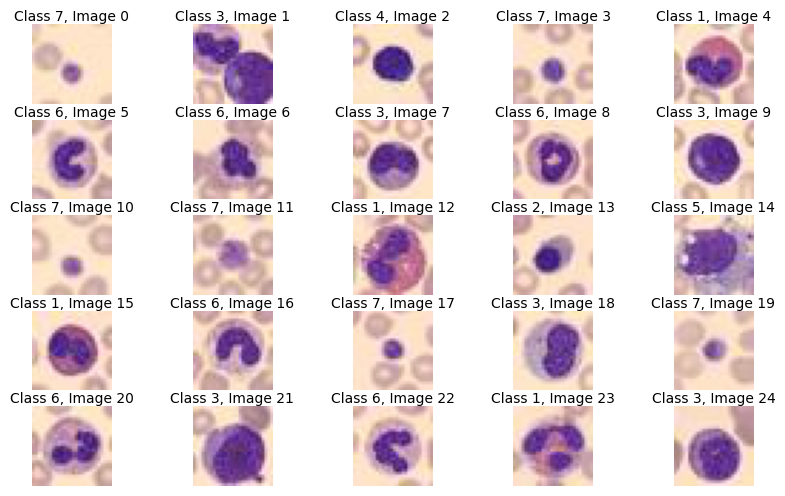

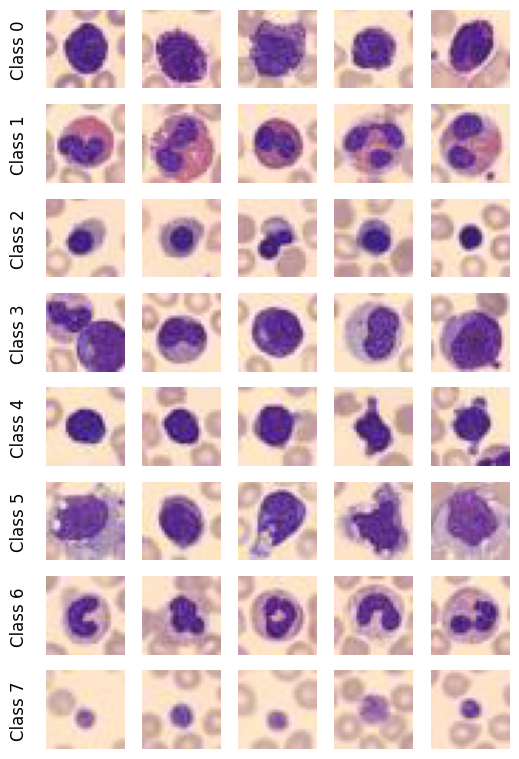

In [2]:
# function: plot examples with class labels
def plot_examples(data, class_labels, n_rows=5, n_cols=5):
    """Plot a grid of bloodMNIST examples of a specified size."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
            # Print the class label on top of the subplot
            plt.title(f'Class {class_labels[index]}, Image {index}', fontsize=10, va='top')
            
    plt.show()

# function: plot examples for each class
def plot_examples_class(data, labels, class_names, n_image=5, n_class=8):
    """Plot a grid of bloodMNIST examples by class."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_image * 1.2, n_class * 1.2))  
    
    for class_num in range(n_class):

        # Filter data by class
        class_indices = np.where(labels == class_num)[0]
        
        # Label for the class
        class_label = class_names[class_num]
    
        for image in range(n_image):
            
            image_index = class_indices[image]
        
            # Plot the image
            plt.subplot(n_class, n_image, class_num * n_image + image + 1)
            plt.imshow(data[image_index])
            plt.axis('off')
            
            # Add class label on the left of each row
            if image == 0:
                plt.text(-10, data[image_index].shape[0] // 2, class_label, fontsize=12, ha='center', va='center', rotation=90)
    
    plt.show()

    #plot examples first n_rows x n_cols examples
plot_examples(X_train_full, y_train_full, n_rows=5, n_cols=5)

#plot first n_image examples of each class
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7"]
plot_examples_class(X_train_full, y_train_full, class_names, n_image=5, n_class=8)

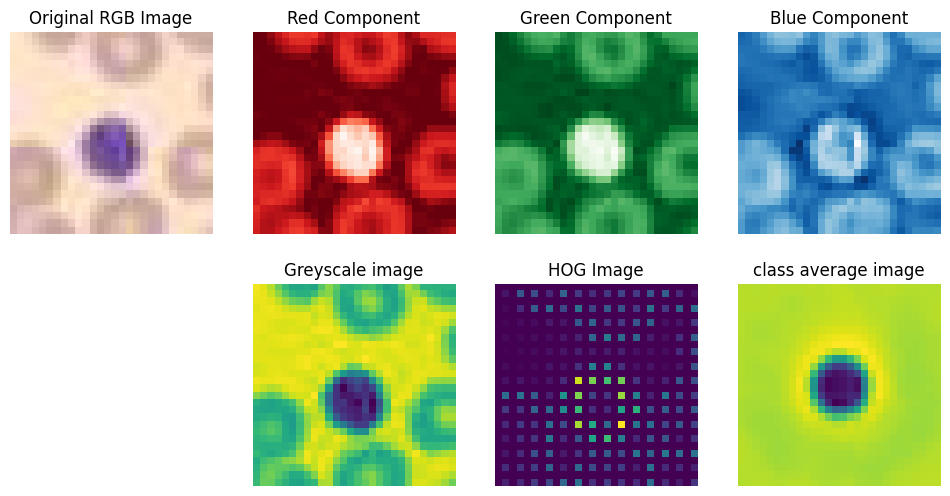

In [3]:
#show example of feature extraction

# define example image
test_image = X_train_full[3]

plt.figure(figsize=(12, 6))

# plot 1: original image
plt.subplot(241)
plt.imshow(test_image)
plt.title('Original RGB Image')
plt.axis('off')

# plot 2,3,4 : RGB channels
r_channel = test_image[:, :, 0]
g_channel = test_image[:, :, 1]
b_channel = test_image[:, :, 2]

plt.subplot(242)
plt.imshow(r_channel, cmap='Reds')
plt.title('Red Component')
plt.axis('off')

plt.subplot(243)
plt.imshow(g_channel, cmap='Greens')
plt.title('Green Component')
plt.axis('off')

plt.subplot(244)
plt.imshow(b_channel, cmap='Blues')
plt.title('Blue Component')
plt.axis('off')


# plot 5: greyscale image to analyze color intensity
greyscale_image = rgb2gray(test_image)
plt.subplot(246)
plt.imshow(greyscale_image)
plt.title('Greyscale image')
plt.axis('off')

# plot 6: HOG image to analyze boundaries
hog_features_2, hog_image_2 = hog(greyscale_image,
                              visualize=True,
                              block_norm='L1', #options: L1, L1-sqrt, L2, L2-Hys
                              pixels_per_cell=(2,2))

plt.subplot(247)
plt.imshow(hog_image_2)
plt.title('HOG Image')
plt.axis('off')

# plot 7: average class image to show average sizes and color values

X_train_mean = X_train_full.mean(axis=3)
X_train_scale = X_train_mean / 255

def average_image(X,y,class_number):
    mask = (y == class_number) 
    X_class = X[mask]
    average_image = np.mean(X_class, axis=0)
    return average_image

avg_img = average_image(X_train_scale, y_train_full, 7)
plt.subplot(248)
plt.imshow(avg_img)
plt.title('class average image')
plt.axis('off')

plt.show()

1.A. Understanding the provided blood labels

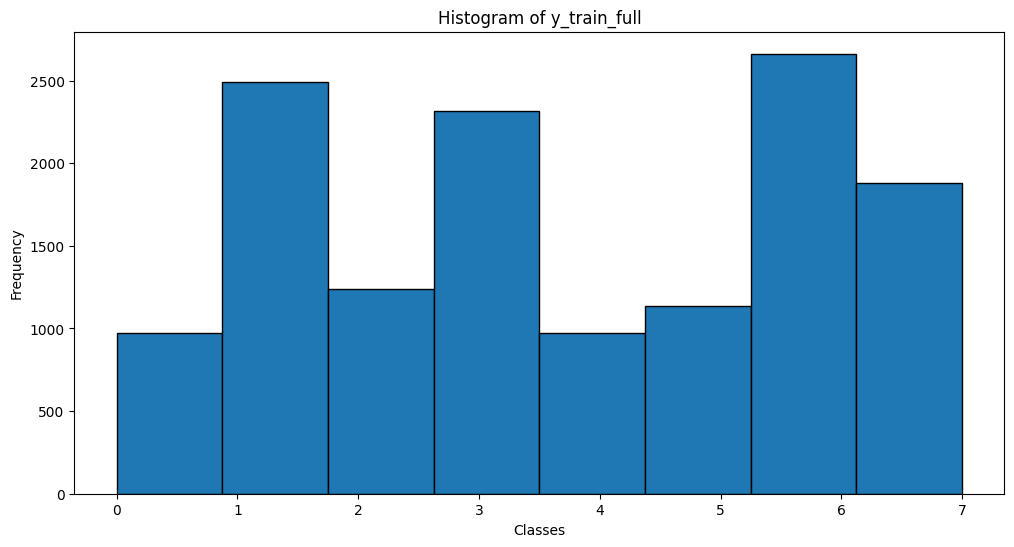

In [4]:
# plot class distribution

#plot size
plt.figure(figsize=(12, 6))

# Create a histogram
plt.hist(y_train_full, bins=8, edgecolor='black', align='mid')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Histogram of y_train_full')

# Show the histogram
plt.show()

1.B. DATA DISTRIBUTION

In [5]:

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

classes_to_augment = [0,2,4,5]

X_augmented = []
y_augmented = []

for class_to_augment in classes_to_augment:
    mask = y_train_full == class_to_augment
    X_to_augment = X_train_full[mask]
    y_to_augment = y_train_full[mask]

    augmented_data = datagen.flow(X_to_augment, y_to_augment, batch_size=len(X_to_augment), shuffle=False)
    
    X_batch, y_batch = next(augmented_data)
    X_augmented.append(X_batch)
    y_augmented.append(y_batch)

# Convert lists to numpy arrays
X_augmented = np.concatenate(X_augmented, axis=0)
y_augmented = np.concatenate(y_augmented, axis=0)

X_train_full_augmented = np.concatenate([X_train_full, X_augmented])
y_train_full_augmented = np.concatenate([y_train_full, y_augmented])



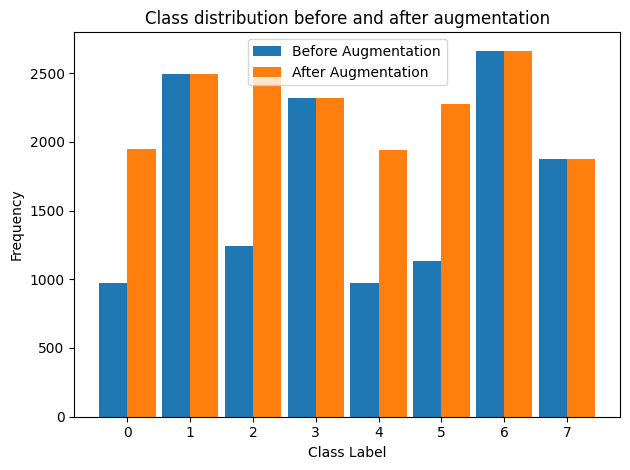

In [6]:
labels = np.unique(y_train_full_augmented)

before_counts = np.bincount(y_train_full)
after_counts = np.bincount(y_train_full_augmented)

# Plotting the histograms
fig, ax = plt.subplots()
width = 0.45

rects1 = ax.bar(labels - width/2, before_counts[labels], width, label='Before Augmentation')
rects2 = ax.bar(labels + width/2, after_counts[labels], width, label='After Augmentation')

ax.set_xlabel('Class Label')
ax.set_ylabel('Frequency')
ax.set_title('Class distribution before and after augmentation')
ax.set_xticks(labels)
ax.legend()

plt.tight_layout()
plt.show()

1.C. IMAGE CHARACTERISTICS

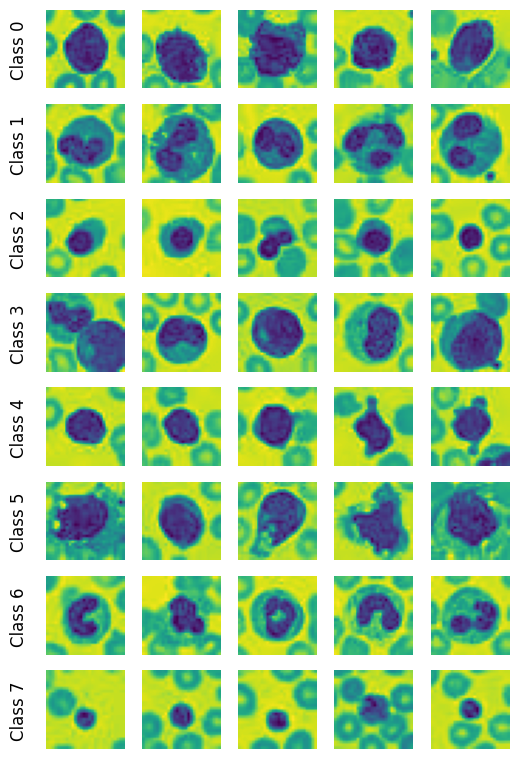

In [7]:
# plot scaled and averaged images
X_train_mean = X_train_full.mean(axis=3)
X_train_scale = X_train_mean / 255

plot_examples_class(X_train_scale, y_train_full, class_names, n_image=5, n_class=8)

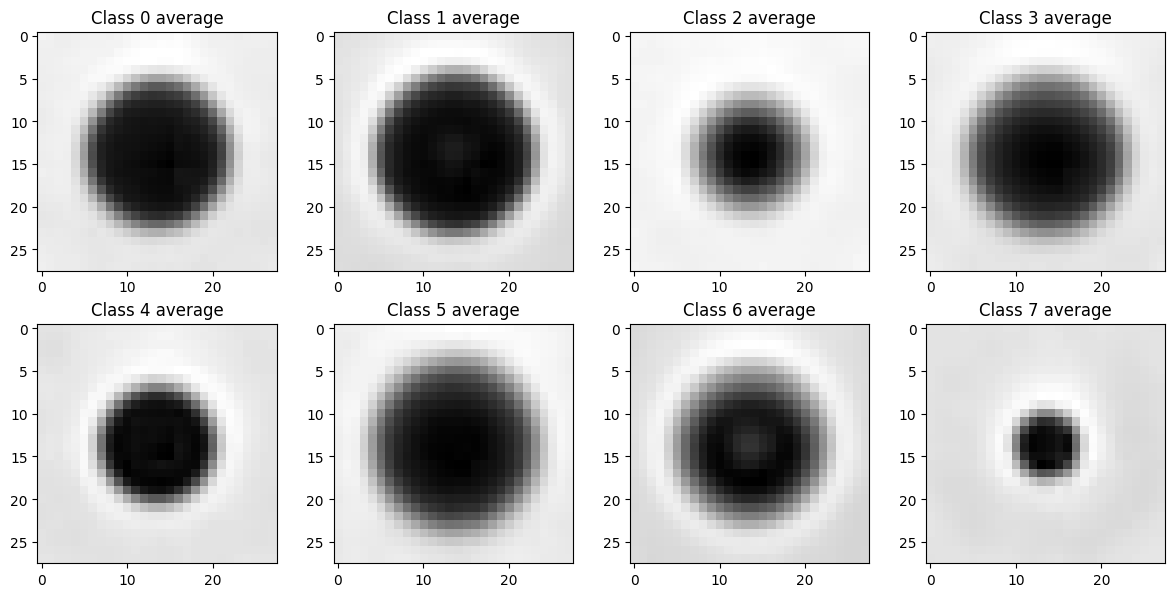

In [8]:
# plot average images to how average sizes and color intensities

def average_image(X,y,class_number):
    mask = (y == class_number) 
    X_class = X[mask]
    average_image = np.mean(X_class, axis=0)
    return average_image

fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Create a 2x4 grid of subplots

for class_number in range(8):
    row = class_number // 4
    col = class_number % 4
    avg_img = average_image(X_train_scale, y_train_full, class_number)
    avg_img = avg_img.astype(np.float32) 
    axes[row, col].imshow(avg_img, cmap='gray')
    axes[row, col].set_title(f'Class {class_number} average')

plt.tight_layout()
plt.show()

1.D. FACTORS WHICH MAKES ANALYSIS HARD (see report)

2.1. Fully Connected Neural Network (FCNN MLP)

In [9]:
#pre-processing
X_train_full_mlp = X_train_full/255
X_test_mlp = X_test/255

In [10]:
#model
def build_mlp(
    n_hidden_layers=4, n_hidden_neurons=100,
    activation_function="relu", input_shape=[28,28,3]
):
    
    model = keras.models.Sequential()
    
    # Add the input layer
    model.add(keras.layers.Flatten(input_shape=input_shape))
    
    # Add the hidden layers with desired size and activation function
    for layer in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_hidden_neurons, activation=activation_function))
        
    # Add the output layer for 10 class classification
    model.add(keras.layers.Dense(8, activation="softmax"))
    
    return model


# Create a KerasClassifier object which works with sklearn grid searches
keras_mlp_classifier = KerasClassifier(build_mlp,
                                   n_hidden_layers=4,
                                   n_hidden_neurons=100,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   optimizer__learning_rate=0.01,
                                   metrics=["accuracy"]
                                  )

In [12]:
#hyperparameter tuning
    

param_grid = {
    "n_hidden_neurons": [200, 300, 400],
    "optimizer__learning_rate": [0.1, 0.01, 0.001],
    "activation_function": ["relu", "sigmoid", "tanh"],
}

'''
#reserved to test gridsearch
param_grid = {
    "n_hidden_neurons": [300],
    "optimizer__learning_rate": [0.01],
    "activation_function": ["tanh"]
}
'''

mlp_grid_search_cv = GridSearchCV(keras_mlp_classifier, param_grid, cv=5, verbose = 2, n_jobs=1)
mlp_grid_results= mlp_grid_search_cv.fit(X_train_full_mlp, y_train_full, epochs=50)

#runtime 353 minutes

Fitting 5 folds for each of 27 candidates, totalling 135 fits


2023-10-15 12:36:19.673110: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-10-15 12:36:19.673137: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-15 12:36:19.673145: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-15 12:36:19.673322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-15 12:36:19.673586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50
  1/342 [..............................] - ETA: 1:30 - loss: 3.4732 - accuracy: 0.1875

2023-10-15 12:36:20.192070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


342/342 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0745
Epoch 2/50
342/342 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0712
Epoch 3/50
342/342 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0712
Epoch 4/50
342/342 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0712
Epoch 5/50
342/342 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0712
Epoch 6/50
342/342 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0712
Epoch 7/50
342/342 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.0712
Epoch 8/50
342/342 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0712
Epoch 9/50
342/342 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0712
Epoch 10/50
342/342 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0712
Epoch 11/50
342/342 [===================

In [13]:
#gridsearch stats
mlp_best_model = mlp_grid_results.best_estimator_
mlp_means_time = mlp_grid_results.cv_results_['mean_fit_time']
mlp_std_time = mlp_grid_results.cv_results_['std_fit_time']
mlp_means = mlp_grid_results.cv_results_['mean_test_score']
mlp_stds = mlp_grid_results.cv_results_['std_test_score']
mlp_params = mlp_grid_results.cv_results_['params']

cv_results_df = pd.DataFrame(mlp_grid_results.cv_results_)

# Create a pivot table
pivot_table = pd.pivot_table(cv_results_df, 
                             values=['mean_fit_time', 'mean_test_score'], 
                             index=['param_n_hidden_neurons', 'param_optimizer__learning_rate'], 
                             columns='param_activation_function')

pivot_table = pivot_table.rename_axis(index={'param_n_hidden_neurons': 'hidden_neurons', 
                                             'param_optimizer__learning_rate': 'learning_rate'})
pivot_table = pivot_table.rename_axis(columns={'param_activation_function':'activation_function'})

# Display the pivot table
print(pivot_table)

                             mean_fit_time                          \
activation_function                   relu     sigmoid        tanh   
hidden_neurons learning_rate                                         
200            0.001             77.982700  293.826656  774.725064   
               0.010             77.883643   85.817205   88.560621   
               0.100             81.860849   86.322355   89.094731   
300            0.001             88.824768   87.653167   98.461499   
               0.010             85.714181  407.979600  100.730487   
               0.100             84.604137  665.508047   91.804580   
400            0.001             91.138991  103.334307   97.156397   
               0.010             90.842212   92.884392   95.214434   
               0.100             92.351095   89.013874   92.078645   

                             mean_test_score                      
activation_function                     relu   sigmoid      tanh  
hidden_neurons learning_r

In [14]:
#results and final model
print(mlp_grid_results.best_params_)
best_model=mlp_grid_results.best_estimator_
best_score = best_model.score(X_test_mlp,y_test)
print(f'Best test score: {best_score}\n')

print(classification_report(y_test, mlp_grid_results.predict(X_test_mlp)))
print(confusion_matrix(y_test, mlp_grid_results.predict(X_test_mlp)))

{'activation_function': 'tanh', 'n_hidden_neurons': 300, 'optimizer__learning_rate': 0.01}
107/107 [==============================] - 0s 2ms/step
Best test score: 0.8329921029540801

107/107 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.59      0.66       244
           1       0.91      0.97      0.94       623
           2       0.96      0.73      0.83       310
           3       0.70      0.65      0.67       579
           4       0.68      0.86      0.76       243
           5       0.74      0.65      0.69       284
           6       0.84      0.95      0.89       666
           7       0.98      1.00      0.99       470

    accuracy                           0.83      3419
   macro avg       0.82      0.80      0.80      3419
weighted avg       0.83      0.83      0.83      3419

107/107 [==============================] - 0s 2ms/step
[[143  11   0  53  25  12   0   0]
 [  0 605   0   1   0

2. Convolutional Neural Network (CNN)

In [8]:
#Pre-processing

X_train_full_cnn = X_train_full_augmented/255
X_test_cnn = X_test/255

X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn = train_test_split(X_train_full_cnn, y_train_full_augmented, train_size=0.9)


In [18]:
#CNN Model

run_count = 0

def create_model(optimizer='adam', dropout_rate=0.5, num_filters_1=32, num_filters_2=64, kernel_size=3, learning_rate=0.01):

    global run_count

    model = keras.Sequential([
        keras.Input(shape=(28, 28, 3)),
        keras.layers.Conv2D(num_filters_1, kernel_size=(kernel_size, kernel_size), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(num_filters_2, kernel_size=(kernel_size, kernel_size), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(10, activation="softmax"),
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    print(run_count)
    run_count+=1

    return model

model = KerasClassifier(model=create_model, optimizer='adam', dropout_rate=0.5, num_filters_1=32, num_filters_2=64, kernel_size=3, learning_rate=0.01, epochs=10, verbose=0)


In [ ]:
#CNN Hyperparameter Tuning

run_count = 0

param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.1, 0.3, 0.5],
    'num_filters_1': [32, 64],
    'num_filters_2': [64, 128],
    'kernel_size': [3, 5],
    'learning_rate': [0.01, 0.001]
}


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train_cnn, y_train_cnn)

#runtime 181 minutes




In [ ]:
#CNN Pivot Table (available in report appendix)

cnn_best_model = grid_result.best_estimator_
cnn_means_time = grid_result.cv_results_['mean_fit_time']
cnn_std_time = grid_result.cv_results_['std_fit_time']
cnn_means = grid_result.cv_results_['mean_test_score']
cnn_stds = grid_result.cv_results_['std_test_score']
cnn_params = grid_result.cv_results_['params']

cv_results_df = pd.DataFrame(grid_result.cv_results_)

pivot_table = pd.pivot_table(cv_results_df, 
                             values=['mean_fit_time', 'mean_test_score'], 
                             index=[
                                 'param_optimizer', 
                                 'param_dropout_rate', 
                                 'param_num_filters_1', 
                                 'param_num_filters_2',
                                 'param_kernel_size',
                                 'param_learning_rate'
                             ], 

                             aggfunc={
                                 'mean_fit_time': ['mean', 'std'],
                                 'mean_test_score': ['mean', 'std']
                             })


pivot_table = pivot_table.rename_axis(index={
    'param_optimizer': 'optimizer', 
    'param_dropout_rate': 'dropout_rate',
    'param_num_filters_1': 'num_filters_1',
    'param_num_filters_2': 'num_filters_2',
    'param_kernel_size': 'kernel_size',
    'param_learning_rate': 'learning_rate'
})

print(pivot_table)


In [23]:
#CNN Final Model and Results


X_test_cnn = X_test_cnn.astype('float32')

print(grid_result.best_params_)
best_model=grid_result.best_estimator_
best_score = best_model.score(X_test_cnn,y_test)
print(f'Best test score: {best_score}\n')

print(classification_report(y_test, grid_result.predict(X_test_cnn)))
print(confusion_matrix(y_test, grid_result.predict(X_test_cnn)))

{'dropout_rate': 0.1, 'kernel_size': 5, 'learning_rate': 0.001, 'num_filters_1': 64, 'num_filters_2': 128, 'optimizer': 'adam'}
Best test score: 0.8973384030418251

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       244
           1       0.97      0.98      0.98       623
           2       0.98      0.87      0.92       310
           3       0.71      0.87      0.78       579
           4       0.94      0.84      0.88       243
           5       0.88      0.65      0.75       284
           6       0.94      0.97      0.96       666
           7       1.00      1.00      1.00       470

    accuracy                           0.90      3419
   macro avg       0.90      0.86      0.88      3419
weighted avg       0.90      0.90      0.90      3419

[[173   6   0  58   5   2   0   0]
 [  5 613   2   2   0   0   1   0]
 [  1   1 271  24   6   1   6   0]
 [ 25   5   1 504   2  20  22   0]
 [  3   0   3  30 203   2   2   0]
 [  5   1

3. Random Forest Model

In [9]:
#Random Forest Preprocessing

X_train_rf = X_train_cnn.reshape(X_train_cnn.shape[0], -1)
X_valid_rf = X_valid_cnn.reshape(X_valid_cnn.shape[0], -1)


In [10]:
#Random Forest Model
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_rf, y_train_cnn)

RandomForestClassifier()

In [11]:
#Random Forest Hyperparameter Tuning

param_grid = {
    'n_estimators': [50, 100, 200, 250],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, 
                           cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train_rf, y_train_cnn)

#runtime 11

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 250]},
             verbose=2)

In [12]:
#Random Forest Pivot Table

rf_cv_results = pd.DataFrame(grid_search.cv_results_)

pivot_table = pd.pivot_table(rf_cv_results, 
                             values=['mean_fit_time', 'mean_test_score'], 
                             index=['param_n_estimators', 'param_max_features', 'param_max_depth'], 
                            )

pivot_table = pivot_table.rename_axis(index={
    'param_n_estimators': 'n_estimators', 
    'param_max_features': 'max_features',
    'param_max_depth': 'max_depth'
})

print(pivot_table)

                                     mean_fit_time  mean_test_score
n_estimators max_features max_depth                                
50           log2         10              9.323568         0.762025
                          20             13.016553         0.780364
                          30             14.132784         0.781229
             sqrt         10             36.604530         0.772892
                          20             53.175322         0.790738
                          30             57.231373         0.791355
100          log2         10             18.599347         0.770238
                          20             25.926094         0.795740
                          30             28.633729         0.794875
             sqrt         10             70.263046         0.781414
                          20            105.940085         0.802902
                          30            114.745617         0.798704
200          log2         10             35.1541

In [16]:
#Random Forest Final Model and Results

X_test_rf = X_test_cnn.reshape(X_test_cnn.shape[0], -1)

print(grid_search.best_params_)
best_model=grid_search.best_estimator_
best_score = best_model.score(X_test_rf,y_test)
print(f'Best test score: {best_score}\n')

print(classification_report(y_test, grid_search.predict(X_test_rf)))
print(confusion_matrix(y_test, grid_search.predict(X_test_rf)))

{'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 250}
Best test score: 0.8461538461538461

              precision    recall  f1-score   support

           0       0.73      0.59      0.66       244
           1       0.91      0.92      0.92       623
           2       0.90      0.85      0.88       310
           3       0.70      0.74      0.72       579
           4       0.79      0.86      0.82       243
           5       0.70      0.67      0.69       284
           6       0.91      0.92      0.92       666
           7       1.00      0.99      0.99       470

    accuracy                           0.85      3419
   macro avg       0.83      0.82      0.82      3419
weighted avg       0.85      0.85      0.85      3419

[[145  11   1  56  20  10   1   0]
 [  3 572   4  13   4  15  12   0]
 [  6   1 265  22   9   0   7   0]
 [ 20  14   3 430  20  52  40   0]
 [  7   0   3  21 210   1   1   0]
 [ 16  15   0  60   1 191   1   0]
 [  1  13  13  16   3   4 616   0]
 [  

4. SVM with PCA

In [20]:
#pre-processing

#flatten X_train_full
X_train_full_flattened = X_train_full.reshape(len(X_train_full),-1)
print('Train flattened shape is: ', X_train_full_flattened.shape)

#flatten X_test
X_test_flattened = X_test.reshape(len(X_test),-1)
print('Test flattened shape is: ',X_test_flattened.shape)

#create additional features with HOG (Histogram of Oriented Gradient) 
from skimage.feature import hog

# function: create new features with hog and append it behind the flattened RGB list
def create_features(input_image):
    color_features = input_image.flatten()
    grey_image = rgb2gray(input_image)
    hog_features = hog(grey_image, block_norm='L1', pixels_per_cell=(2,2))
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

#initiate feature list
features_list_train = []
features_list_test = []

# Loop through each image in the array and apply the function
for image in X_train_full:
    features = create_features(image)
    features_list_train.append(features)

for image in X_test:
    features = create_features(image)
    features_list_test.append(features)

# Convert the list of features to a numpy array
features_array_train = np.array(features_list_train)
print('Train feature matrix shape is: ', features_array_train.shape)

features_array_test = np.array(features_list_test)
print('Test feature matrix shape is: ', features_array_test.shape)

# scale feature arrays
scaler = MinMaxScaler()
scaler.fit(features_array_train)
feature_stand_train = scaler.transform(features_array_train)
feature_stand_test = scaler.transform(features_array_test)

# apply PCA to feature arrays
pca = PCA(n_components=.95).fit(feature_stand_train) #265 was found during my last run which explains 50% of var, run time 13 mins
features_pca_train = pca.transform(feature_stand_train)
features_pca_test = pca.transform(feature_stand_test)

# look at new shape
print('Train PCA matrix shape is: ', features_pca_train.shape)
print('Test PCA matrix shape is: ', features_pca_test.shape)

#run time 14 mins

#FOR SVM with PCA, idea is from here https://rpubs.com/Sharon_1684/454441

Train flattened shape is:  (13673, 2352)
Test flattened shape is:  (3419, 2352)
Train feature matrix shape is:  (13673, 14016)
Test feature matrix shape is:  (3419, 14016)
Train PCA matrix shape is:  (13673, 1555)
Test PCA matrix shape is:  (3419, 1555)


In [ ]:
#train val split
from sklearn.model_selection import train_test_split
#X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9)

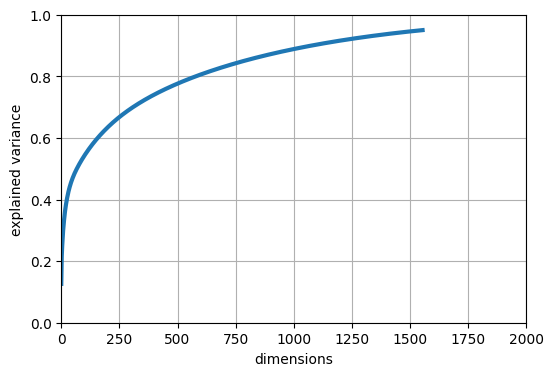

In [21]:
#PCA results
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance vs number of dimensions

plt.figure(figsize = (6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 2000, 0, 1]) 
plt.xlabel("dimensions")
plt.ylabel("explained variance")
plt.grid(True)
plt.show()

In [22]:
#Model

from sklearn import svm

# define svc
svc =svm.SVC(gamma='auto', C=1, kernel='rbf',probability=False, random_state = 0) 
#svc.fit(features_pca_train,y_train_full)

# run time 12mins with probability True and 1mins with probability False

In [23]:
#tuning

param_grid = {
        'C':[0.1, 1, 10],
        'kernel':['rbf','sigmoid','poly'],   
        'gamma':['scale','auto'],      
            }
'''
#reserved to test gridsearch
param_grid = {
        'C':[1],
        'kernel':['rbf'],   
        'gamma':['auto'],      
            }
'''

svc_grid_search_cv = GridSearchCV(svc, param_grid, verbose=2, cv=5, n_jobs=-1)
svc_grid_results= svc_grid_search_cv.fit(features_pca_train, y_train_full)

#runtime 32m

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time= 2.5min
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time= 2.5min
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time= 2.5min
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time= 2.5min
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time= 2.5min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 3.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 3.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 3.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 3.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 3.3min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 4.5min
[CV] END ....................C=0.1, gamma=scale,

In [24]:
#gridsearch stats
svc_best_model = svc_grid_results.best_estimator_
svc_means_time = svc_grid_results.cv_results_['mean_fit_time']
svc_std_time = svc_grid_results.cv_results_['std_fit_time']
svc_means = svc_grid_results.cv_results_['mean_test_score']
svc_stds = svc_grid_results.cv_results_['std_test_score']
svc_params = svc_grid_results.cv_results_['params']

svc_cv_results_df = pd.DataFrame(svc_grid_results.cv_results_)

# Create a pivot table
svc_pivot_table = pd.pivot_table(svc_cv_results_df, 
                             values=['mean_fit_time', 'mean_test_score'], 
                             index=['param_gamma','param_C'], 
                             columns='param_kernel')

svc_pivot_table = svc_pivot_table.rename_axis(index={'param_gamma': 'gamma',
                                                     'param_C': 'C'})
svc_pivot_table = svc_pivot_table.rename_axis(columns={'param_kernel':'kernel'})

# Display the pivot table
print(svc_pivot_table)

           mean_fit_time                         mean_test_score            \
kernel              poly         rbf     sigmoid            poly       rbf   
gamma C                                                                      
auto  0.1     275.115291  186.064166  206.807562        0.194763  0.655233   
      1.0     296.191637  107.663225  120.615277        0.194763  0.794559   
      10.0    202.578856   75.631294   77.091125        0.321948  0.856725   
scale 0.1     246.428884  160.646870  123.008136        0.489944  0.711549   
      1.0     236.859566  117.624836   70.172220        0.751774  0.858042   
      10.0    268.795316  142.635823   49.832666        0.800995  0.875082   

                      
kernel       sigmoid  
gamma C               
auto  0.1   0.587875  
      1.0   0.755358  
      10.0  0.837051  
scale 0.1   0.740657  
      1.0   0.784832  
      10.0  0.725810  


In [26]:
#results and final model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print(svc_grid_results.best_params_)
best_model=svc_grid_results.best_estimator_
best_score = best_model.score(features_pca_test,y_test)
print(f'Best test score: {best_score}\n')

from sklearn.metrics import classification_report, confusion_matrix 
print(classification_report(y_test, svc_grid_results.predict(features_pca_test)))
print(confusion_matrix(y_test, svc_grid_results.predict(features_pca_test)))


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best test score: 0.882714243930974

              precision    recall  f1-score   support

           0       0.77      0.72      0.74       244
           1       0.96      0.95      0.96       623
           2       0.93      0.85      0.89       310
           3       0.75      0.83      0.79       579
           4       0.82      0.80      0.81       243
           5       0.83      0.76      0.79       284
           6       0.92      0.94      0.93       666
           7       0.99      0.99      0.99       470

    accuracy                           0.88      3419
   macro avg       0.87      0.86      0.86      3419
weighted avg       0.88      0.88      0.88      3419

[[176   0   0  37  20  11   0   0]
 [  1 594   0   9   1   4  13   1]
 [  6   0 263  21   7   1   9   3]
 [ 26   4   4 478  12  27  28   0]
 [ 12   0   8  25 195   0   3   0]
 [  8   4   0  53   1 217   1   0]
 [  0  14   7  15   0   2 628   0]
 [  0   0   2   0   1  

The following are available in the report pdf

IV. RESULTS AND DISCUSSIONS

V. CONCLUSION

VI. REFLECTION

APPENDIX: REFERENCES 